In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif, RFE, chi2, SequentialFeatureSelector
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from lazypredict.Supervised import LazyClassifier

pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# Data Loader loads data from UCI-ML Repo
def load_datasets():
    # Classification Datasets
    c_cancer = pd.read_csv("./Classification.CancerMB.csv").iloc[:, :32]
    c_mice_expression = pd.read_csv("./Classification.Mice.Expression.csv")#.iloc[:, :25]
    c_adult_income = pd.read_csv("./Classification.Adult.Income.csv")
    # Regression Datasets
    r_life_expectancy = pd.read_csv("./Regression.Life.Expectancy.csv")
    
    return c_cancer, c_mice_expression, c_adult_income, r_life_expectancy

In [3]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64' and df[column].dtype != 'int64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())

        
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

In [4]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value = False):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

In [5]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64', 'int64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

In [6]:
def LR(df, target_name, folds):
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    # Apply MinMax scaling to ensure non-negative values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize the classifiers
    lr_classifier = LogisticRegression()
    rf_classifier = RandomForestClassifier()

    # Initialize k-fold cross-validation where folds > 0
    for k in folds:
        if k > 0:
            k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

            # Apply chi-squared filter
            X_chi2 = SelectKBest(score_func=chi2, k=10).fit_transform(X_scaled, y)
            lr_chi2_scores = cross_val_score(lr_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
            rf_chi2_scores = cross_val_score(rf_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
            lr_chi2_mean_accuracy = lr_chi2_scores.mean()
            rf_chi2_mean_accuracy = rf_chi2_scores.mean()

            # Apply forward selection wrapper
            lr_forward_selector = SequentialFeatureSelector(lr_classifier, n_features_to_select=10, direction='forward')
            X_forward = lr_forward_selector.fit_transform(X_scaled, y)
            lr_forward_scores = cross_val_score(lr_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
            rf_forward_scores = cross_val_score(rf_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
            lr_forward_mean_accuracy = lr_forward_scores.mean()
            rf_forward_mean_accuracy = rf_forward_scores.mean()

            # Apply backward selection wrapper
            lr_backward_selector = SequentialFeatureSelector(lr_classifier, n_features_to_select=10, direction='backward')
            X_backward = lr_backward_selector.fit_transform(X_scaled, y)
            lr_backward_scores = cross_val_score(lr_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
            rf_backward_scores = cross_val_score(rf_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
            lr_backward_mean_accuracy = lr_backward_scores.mean()
            rf_backward_mean_accuracy = rf_backward_scores.mean()

            # Apply PCA
            pca = PCA(n_components=10)
            X_pca = pca.fit_transform(X_scaled)
            lr_pca_scores = cross_val_score(lr_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
            rf_pca_scores = cross_val_score(rf_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
            lr_pca_mean_accuracy = lr_pca_scores.mean()
            rf_pca_mean_accuracy = rf_pca_scores.mean()

            results.append({
                'k': k,
                'LR with Chi2 Accuracy': lr_chi2_mean_accuracy,
                'RF with Chi2 Accuracy': rf_chi2_mean_accuracy,
                'LR with Forward Selection Accuracy': lr_forward_mean_accuracy,
                'RF with Forward Selection Accuracy': rf_forward_mean_accuracy,
                'LR with Backward Selection Accuracy': lr_backward_mean_accuracy,
                'RF with Backward Selection Accuracy': rf_backward_mean_accuracy,
                'LR with PCA Accuracy': lr_pca_mean_accuracy,
                'RF with PCA Accuracy': rf_pca_mean_accuracy
            })

        else:
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

            # Train and evaluate Logistic Regression and Random Forest models
            lr_classifier.fit(X_train, y_train)
            lr_pred = lr_classifier.predict(X_test)
            lr_accuracy = accuracy_score(y_test, lr_pred)

            rf_classifier.fit(X_train, y_train)
            rf_pred = rf_classifier.predict(X_test)
            rf_accuracy = accuracy_score(y_test, rf_pred)

            results.append({
                'k': k,
                'LR Accuracy': lr_accuracy,
                'RF Accuracy': rf_accuracy
            })

    df_results = pd.DataFrame(results)
    return df_results

In [7]:
# Loading all Datasets into the required variables
c_cancer, c_mice_expression, c_adult_income, r_life_expectancy = load_datasets()

In [8]:
# Load data
c_cancer = pd.read_csv("./Classification.CancerMB.csv").iloc[:, :32]

# Check data types of each column
data_types = c_cancer.dtypes

# Print data types
print(data_types)

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [9]:
c_cancer
# Checking for Null Values
null_check(c_cancer)
# No Null Values present hence Encoding Categorical Data to Numerical
c_cancer = transform_data(c_cancer)
# The target column in 'diagnosis' hence applying Logistic Regression with and without CV.
c_cancer_results = LR(c_cancer, 'diagnosis', [0, 5, 10, 20, 50, 100])
print(c_cancer_results)

Column Name: id
Column DataType: int64
Column has null: False


Column Name: diagnosis
Column DataType: object
Column unique values: ['M' 'B']
Column has null: False


Column Name: radius_mean
Column DataType: float64
Column has null: False


Column Name: texture_mean
Column DataType: float64
Column has null: False


Column Name: perimeter_mean
Column DataType: float64
Column has null: False


Column Name: area_mean
Column DataType: float64
Column has null: False


Column Name: smoothness_mean
Column DataType: float64
Column has null: False


Column Name: compactness_mean
Column DataType: float64
Column has null: False


Column Name: concavity_mean
Column DataType: float64
Column has null: False


Column Name: concave points_mean
Column DataType: float64
Column has null: False


Column Name: symmetry_mean
Column DataType: float64
Column has null: False


Column Name: fractal_dimension_mean
Column DataType: float64
Column has null: False


Column Name: radius_se
Column DataType: float64

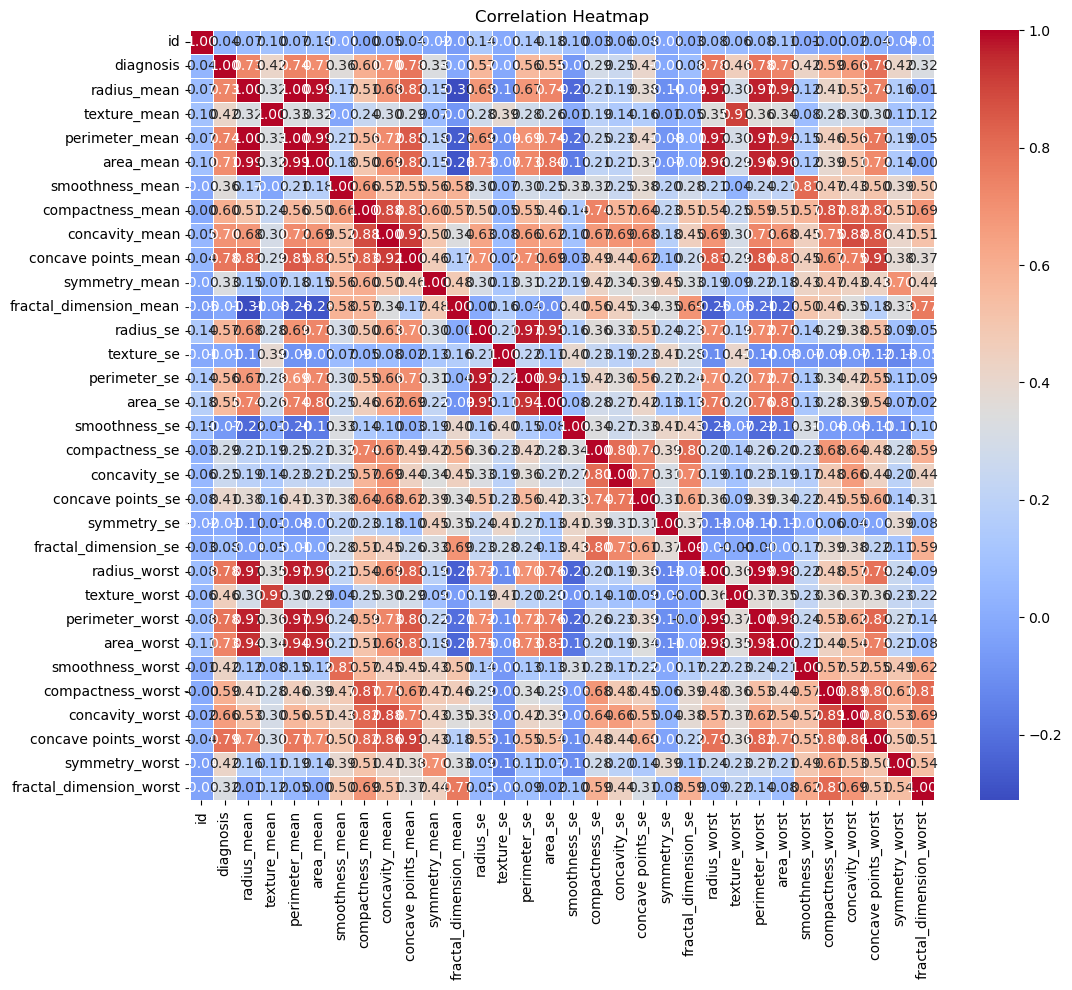

In [10]:
# Assuming df is your DataFrame containing the data
correlation_matrix = c_cancer.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

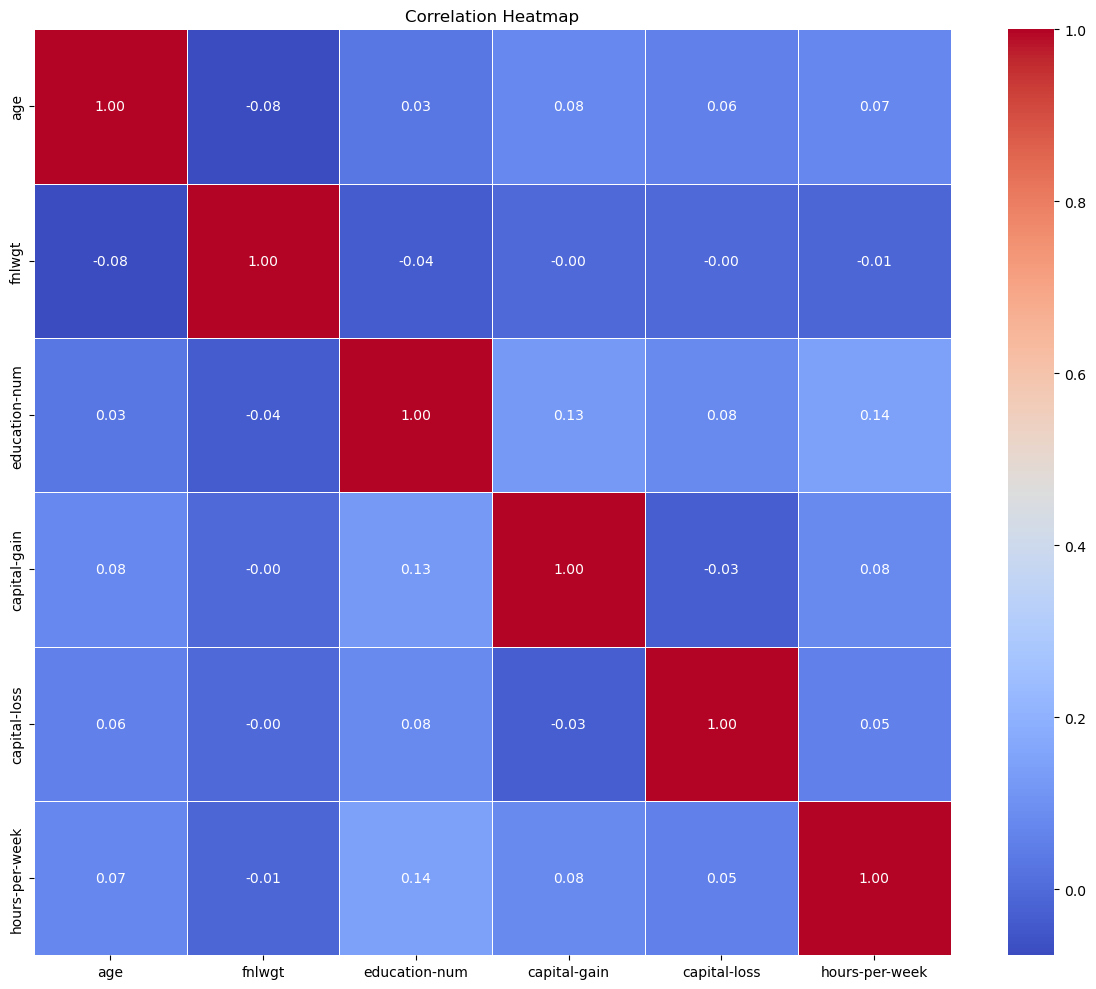

In [13]:
correlation_matrix = c_adult_income.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))  # Adjust the size of the figure
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

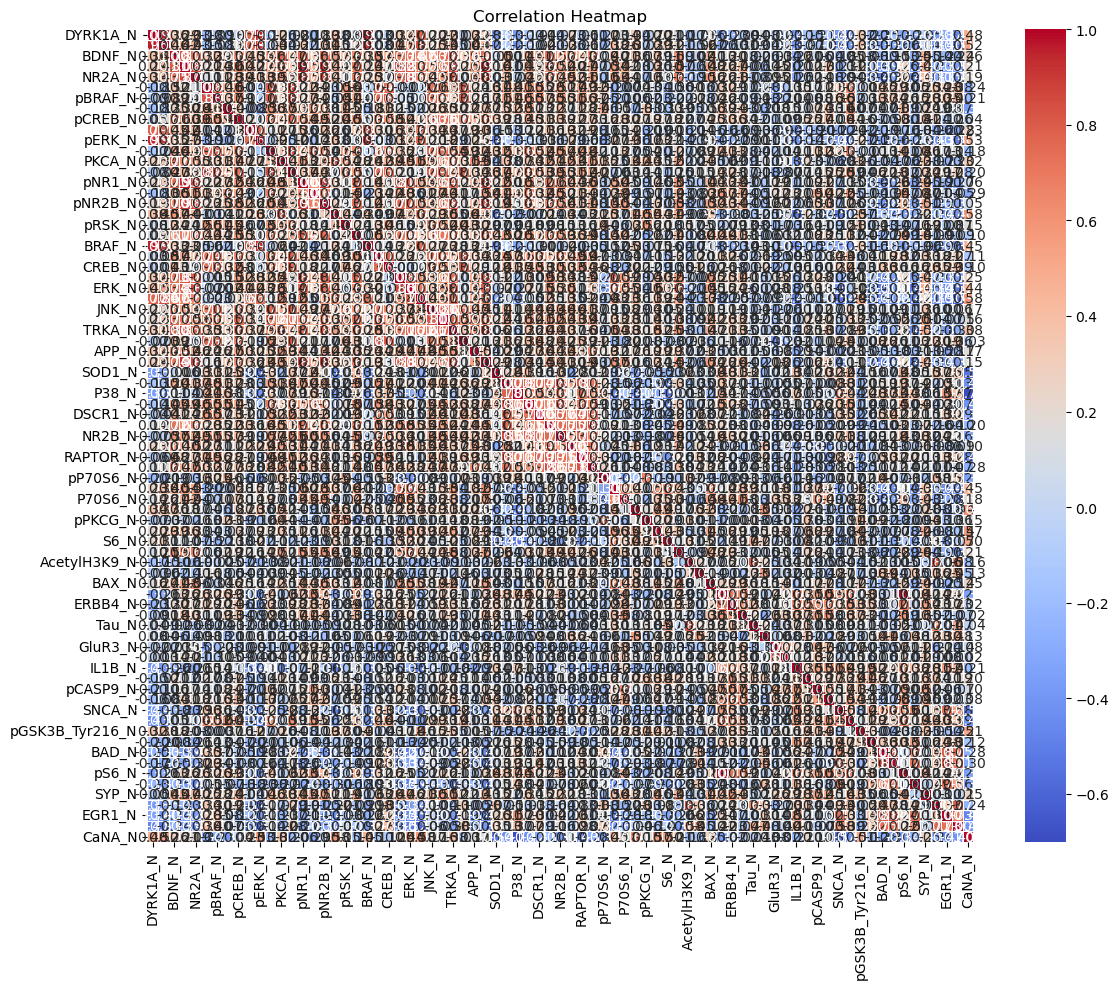

In [14]:
correlation_matrix = c_mice_expression.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))  # Adjust the size of the figure
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()